<a href="https://colab.research.google.com/github/joelvon30-debug/Financial-advisor-/blob/main/Copy_of_Untitled14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scraping page 1...
Scraping page 2...

Scraped 120 products
Saved CSV: sheeel_electronics_120_products.csv
Created ZIP: sheeel_electronics_120_products.zip


,Image,name,price
0,,Powerful Electric Heater 1200W by Powerey,KD 10.000
1,,65 Inch QLED UHD 4K Android Smart TV by Skyworth + Free Wall Bracket + RGB Light,KD 229.900
2,,Smart Android 4K HY300 Projector,KD 24.900
3,,"PS5 1TB Console With EA FC 26 Voucher Bundle (PS5 Slim CD ,PS5 Slim Digital or PS5 Pro)",KD 169.900
4,,Rechargeable 24 Inch LED FHD Android Portable TV by Skyworth with Free Bag,KD 100.000
5,,250ml Steam Cleaner with 6 Replaceable Heads,KD 9.000
6,,20L Inverter Microwave 700W by Midea,KD 19.900
7,,Armrest Gaming Chair with Retractable Footrest by Gamax,KD 29.900
8,,PS5 Slim 1TB Digital Edition Console Fortnite Flowering Chaos Voucher Bundle by Sony,KD 153.500
9,,Orca Hand Blender 600W 500ml,KD 11.990

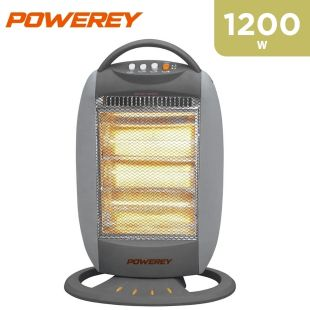
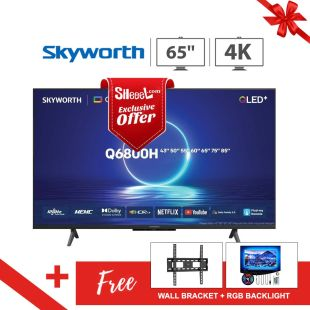
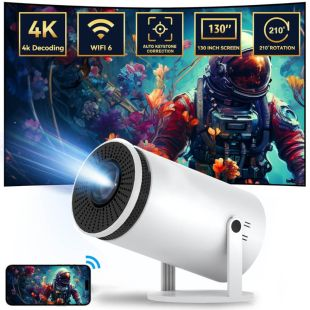
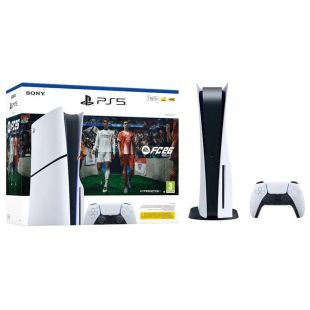
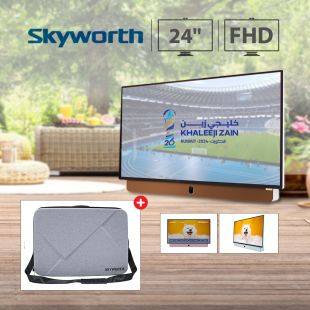
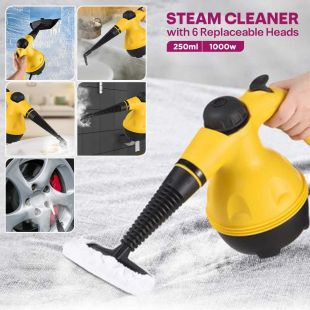
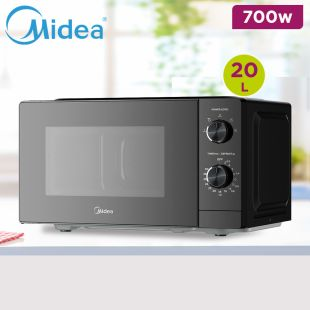
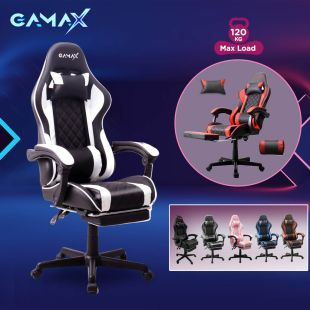
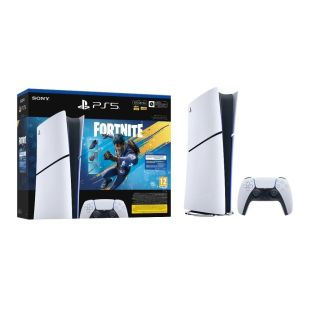
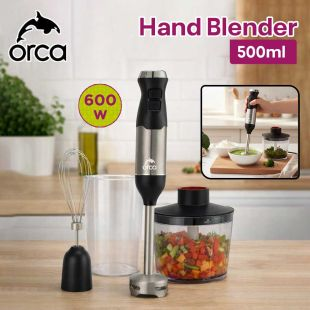
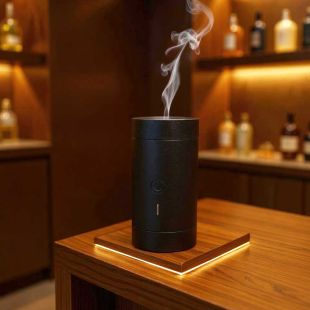
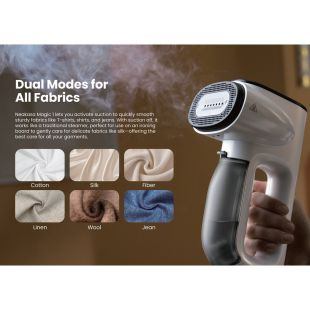
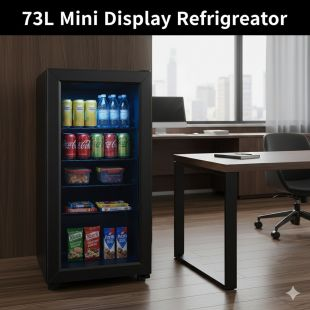
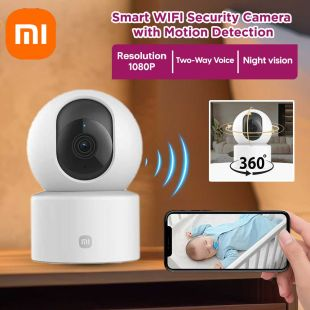
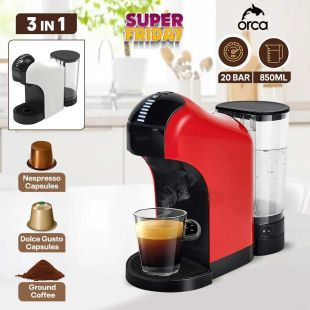
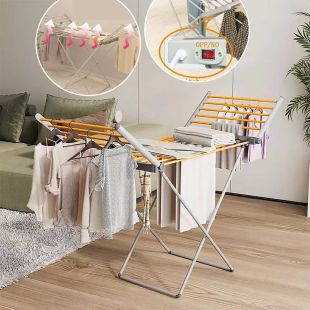
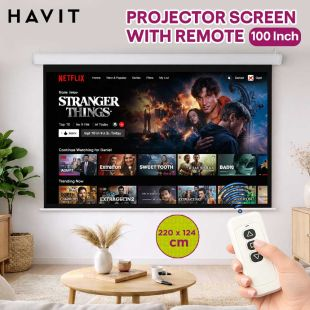
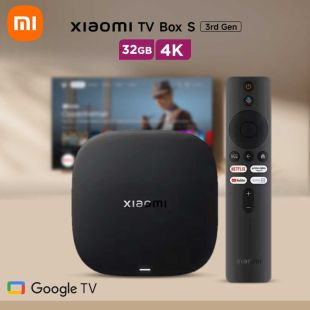
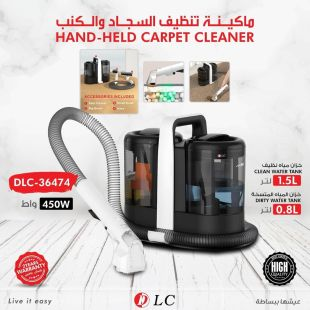
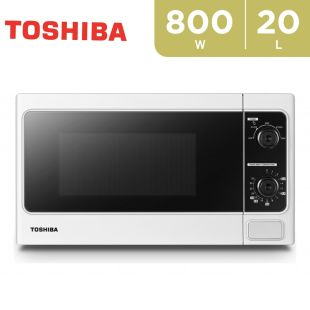
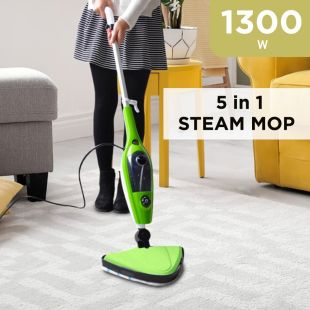
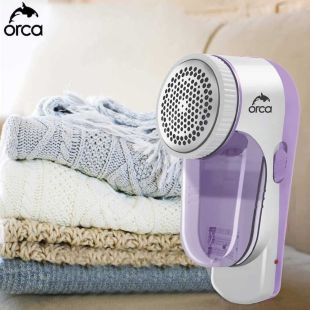
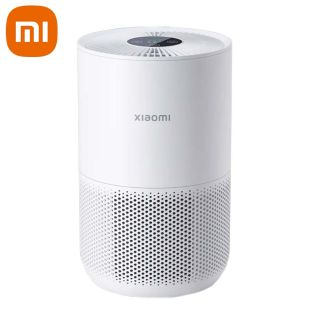
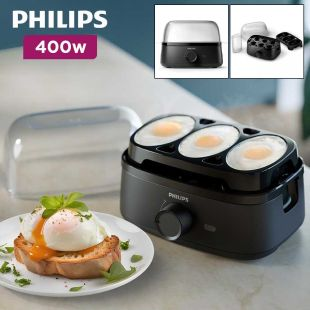
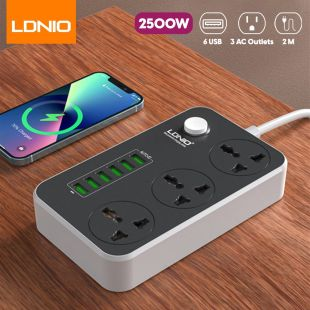
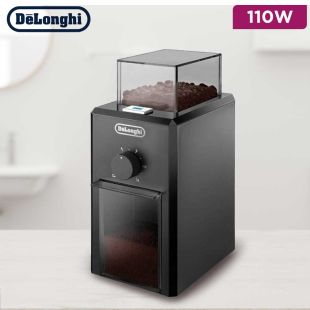
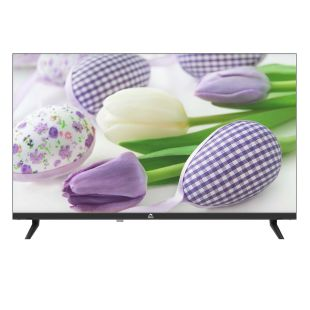
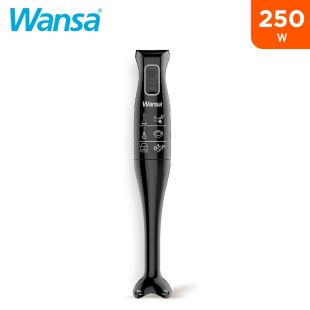
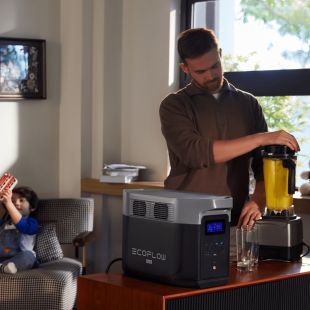
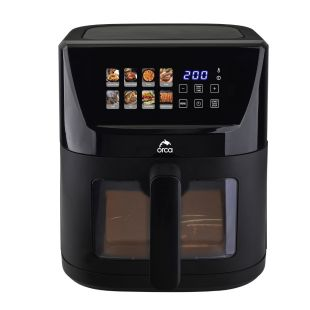
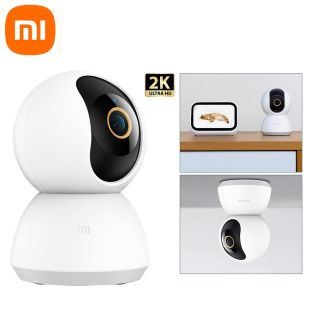
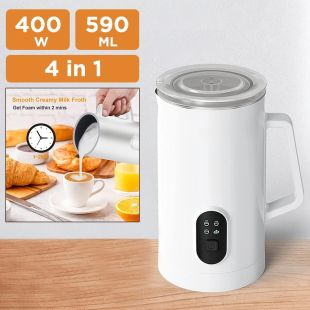
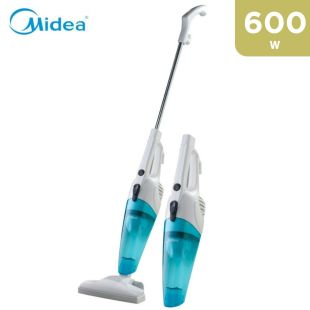
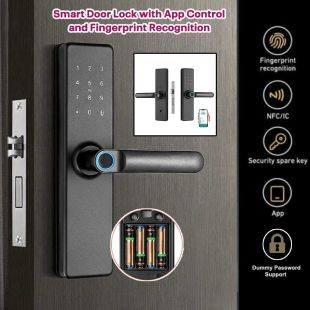
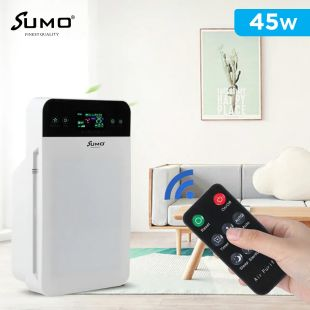
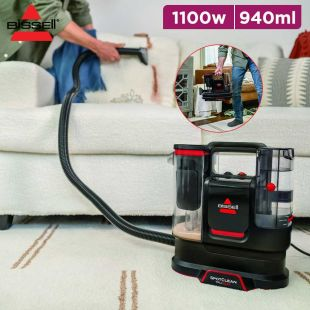
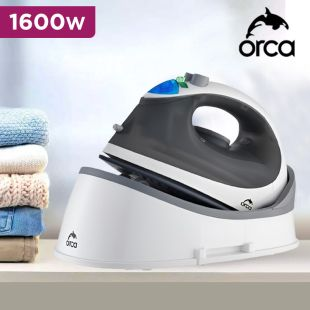
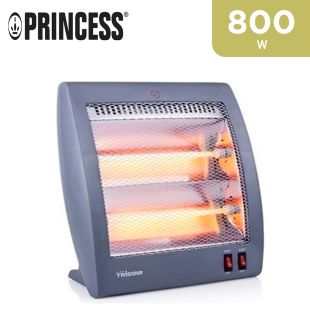
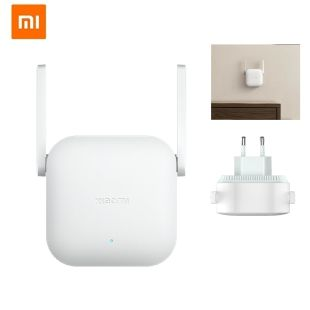
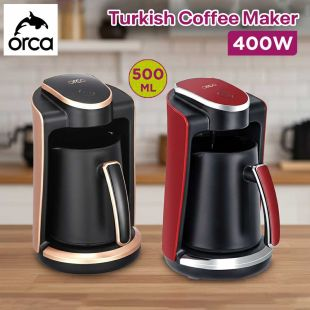
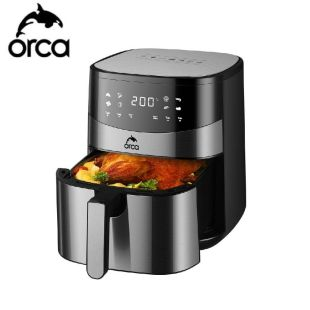
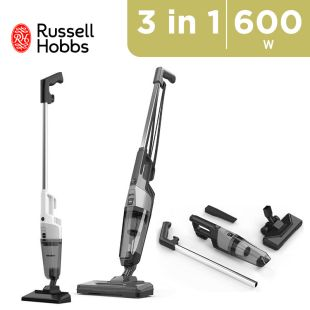
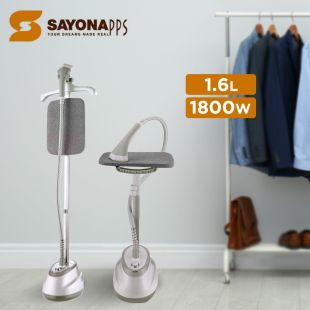
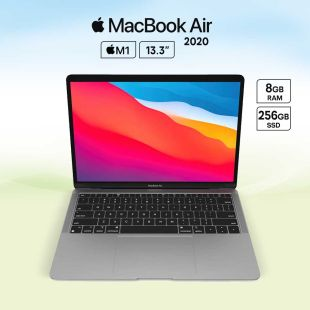
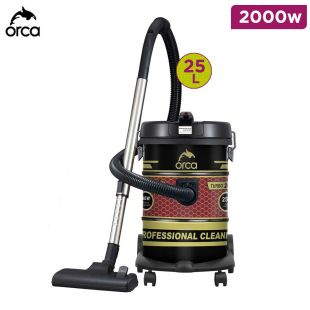
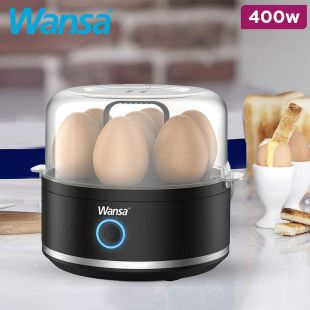
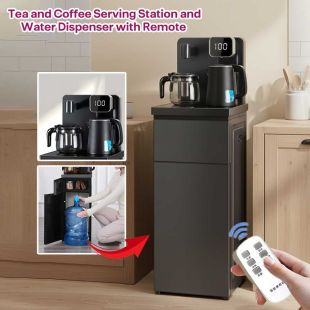
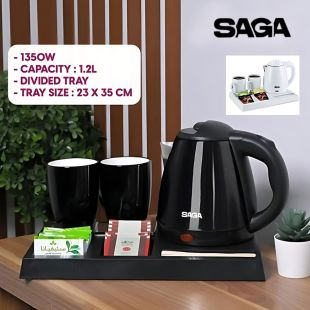
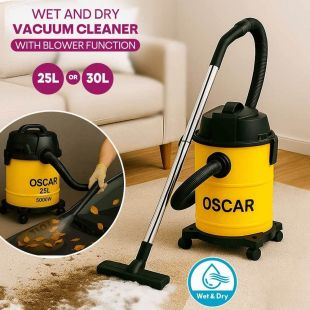
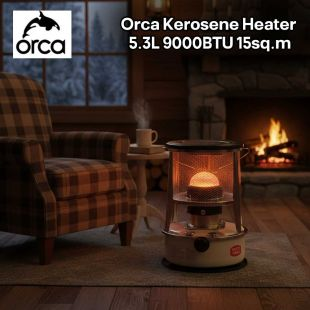
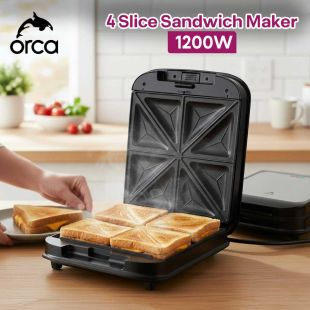
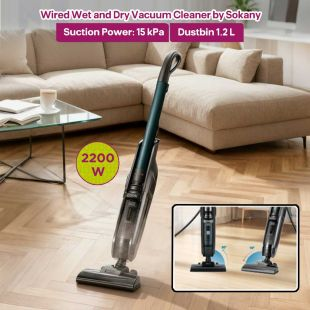
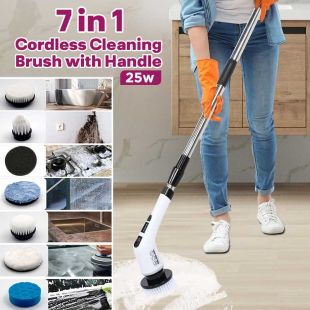
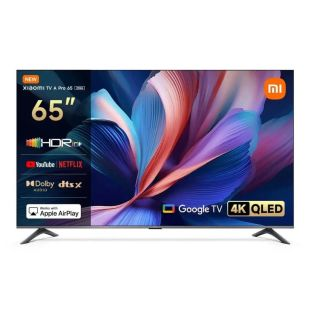
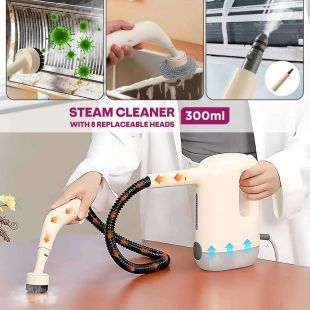
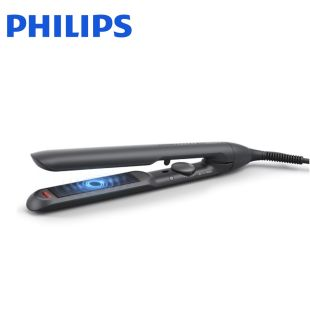
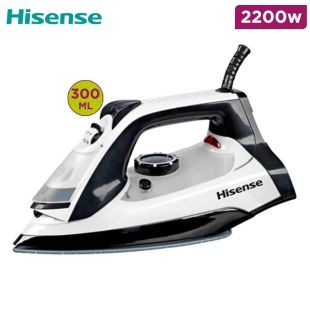
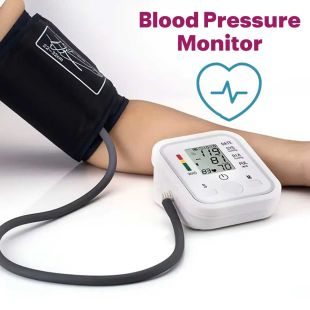
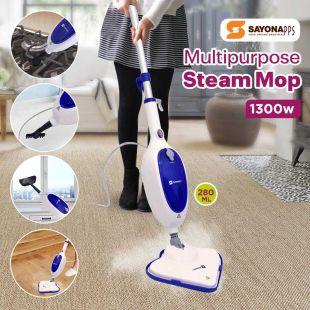
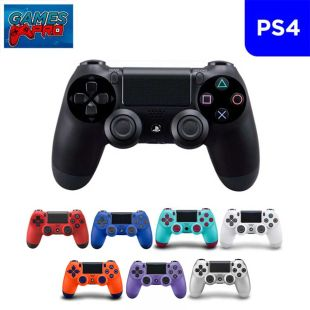
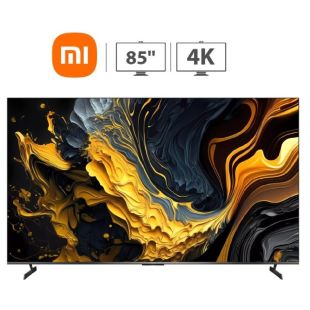
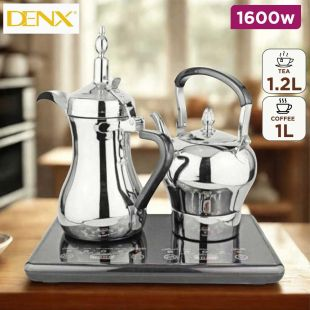
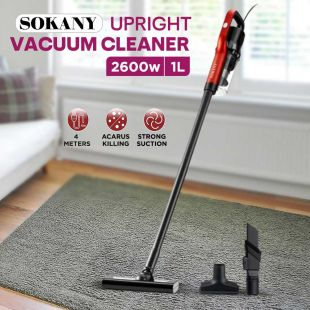
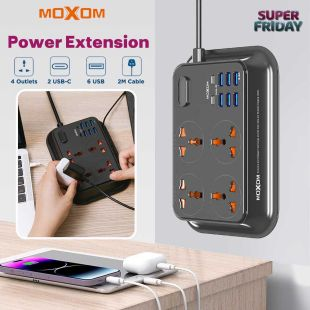
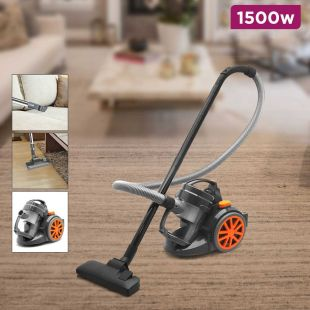
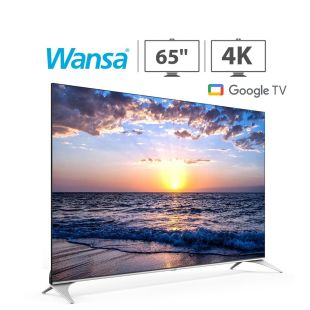
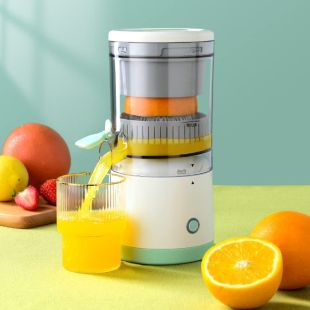
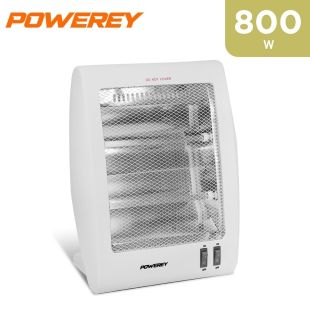
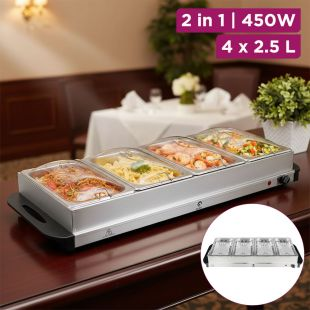
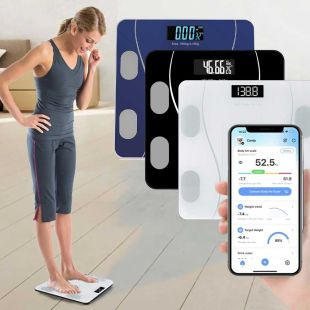
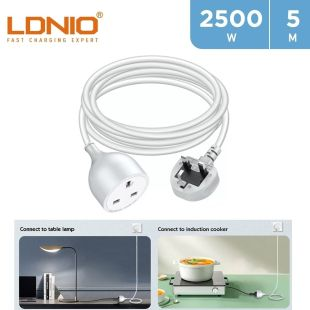
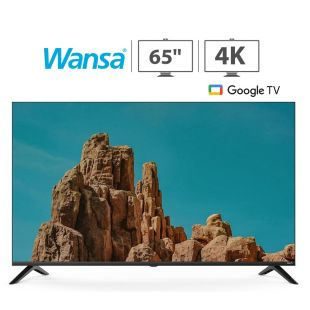
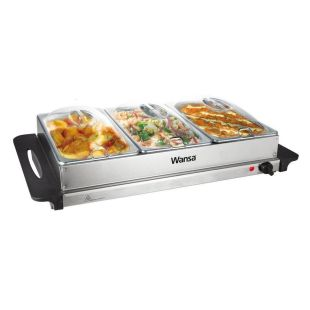
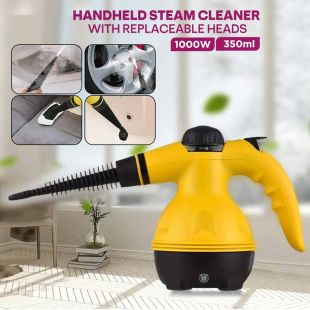
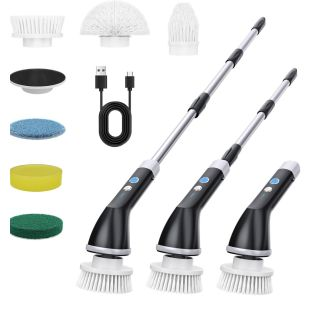
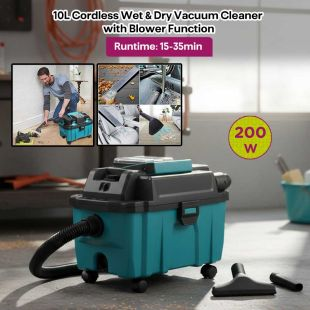
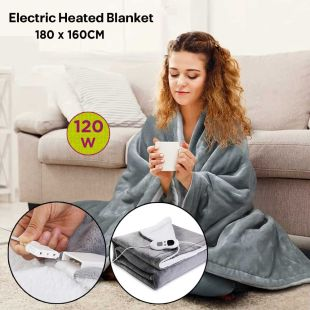
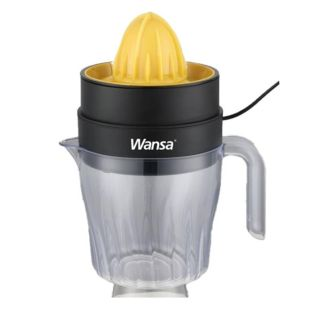
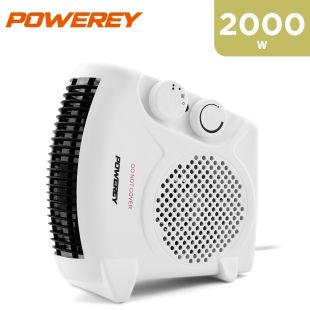
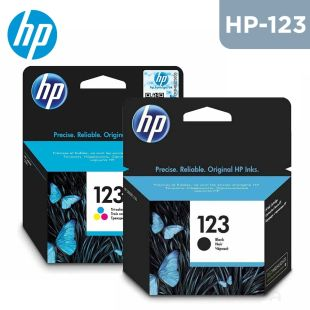
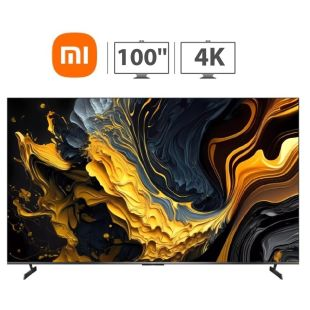
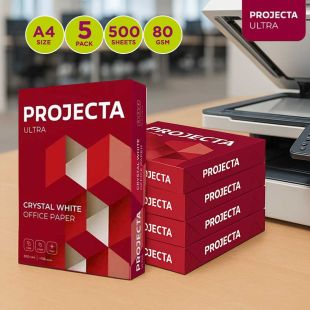
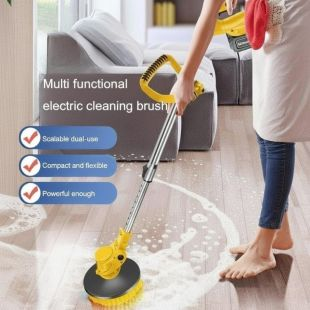
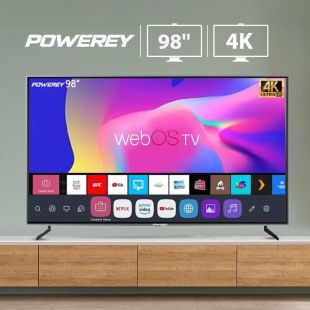
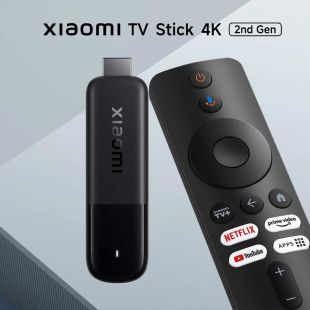
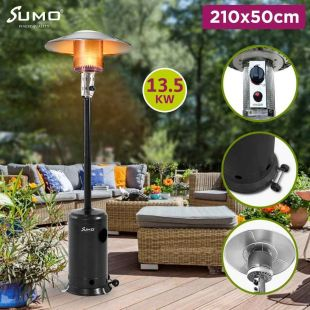
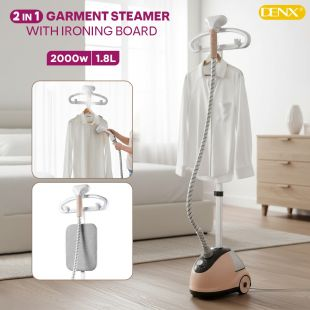
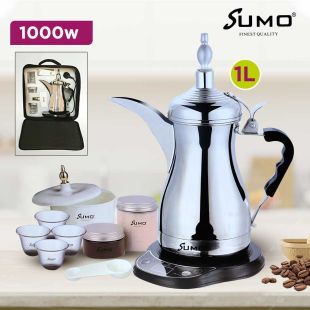
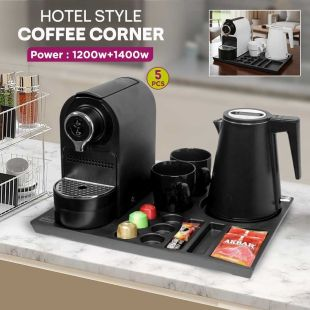
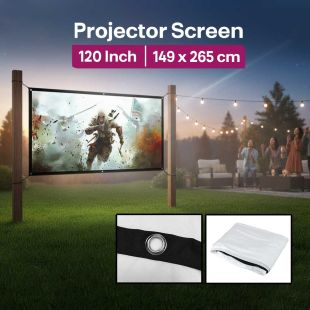
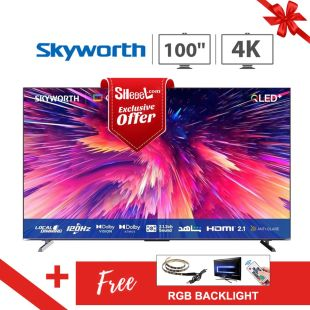
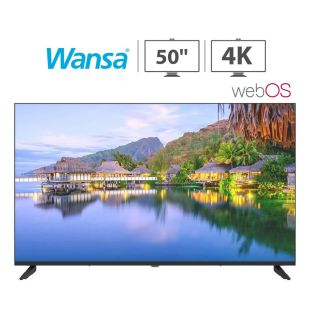
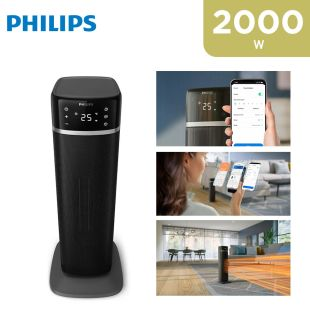
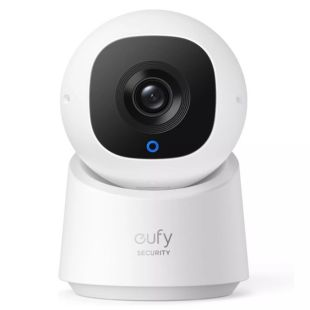
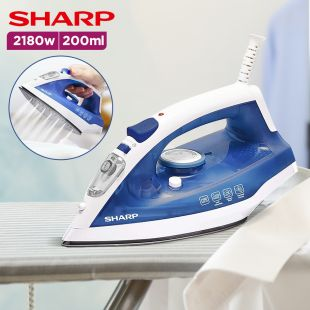
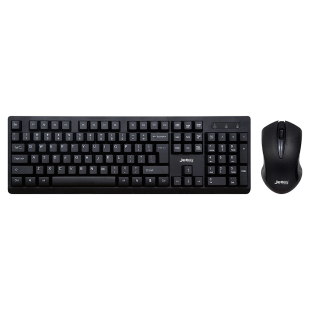
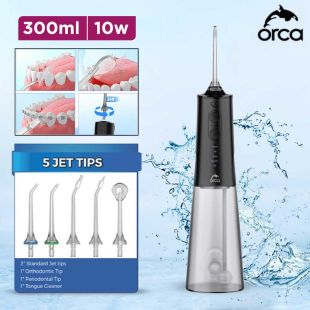
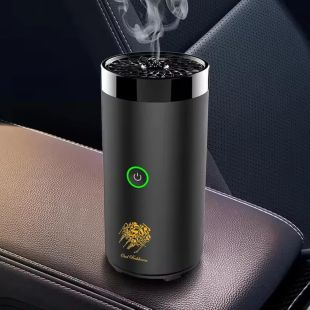
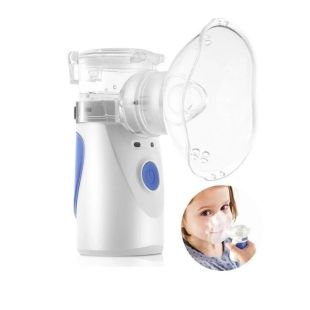
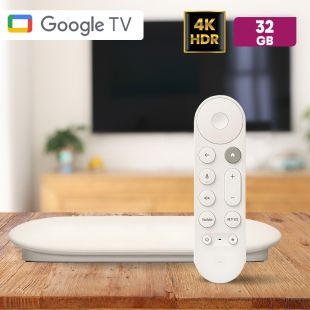
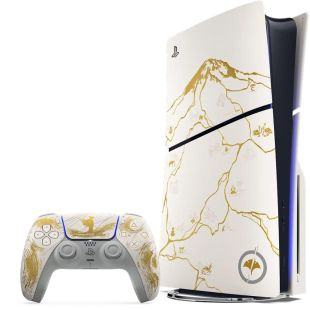
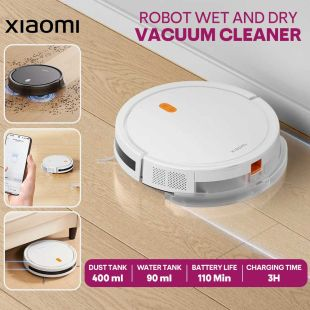
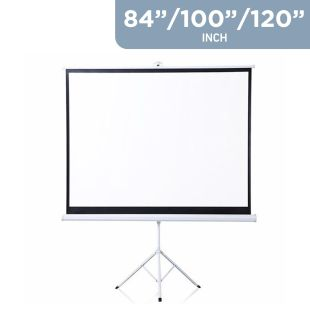
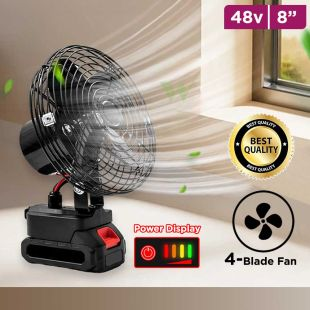
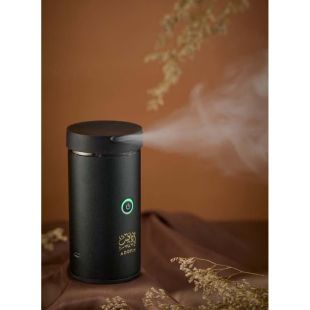
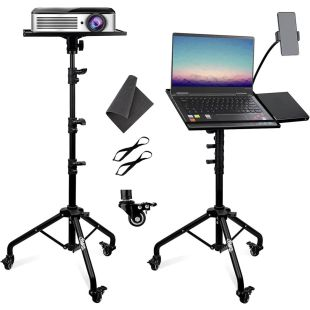
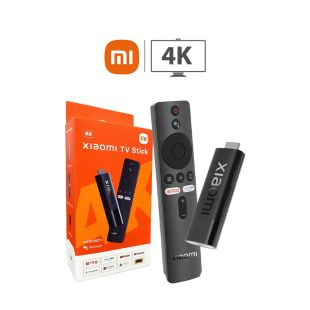
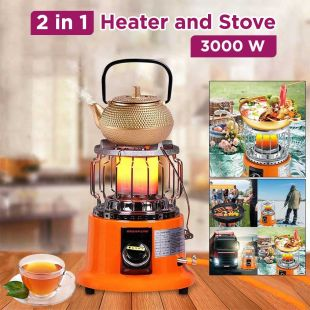
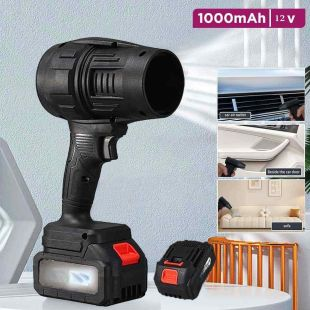
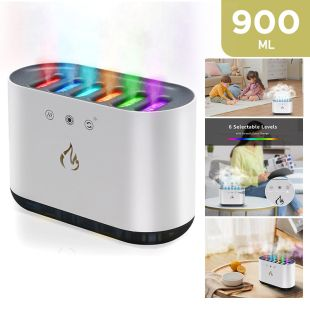
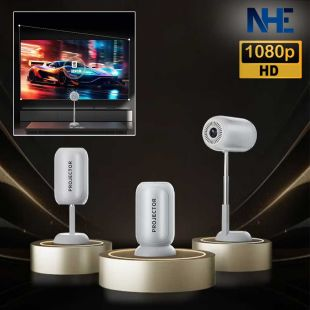
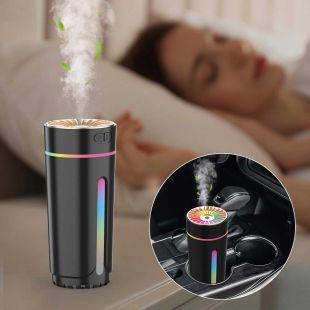
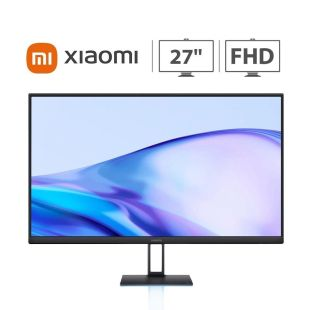
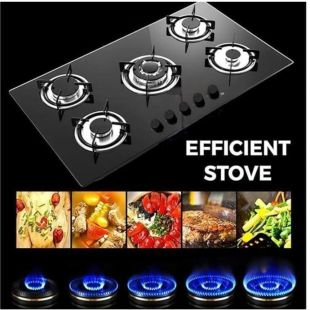
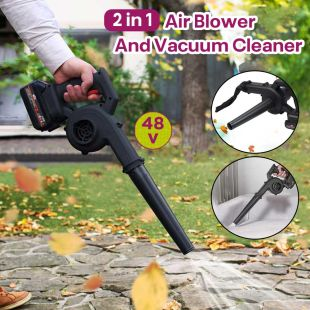
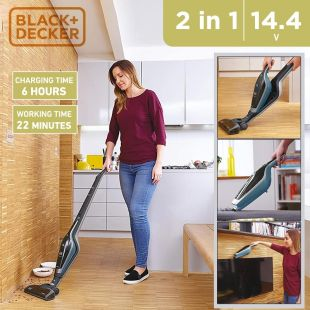
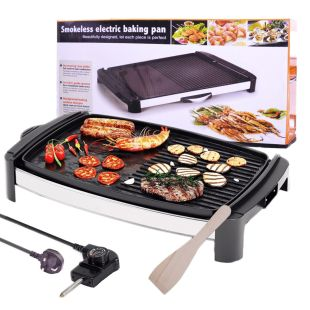
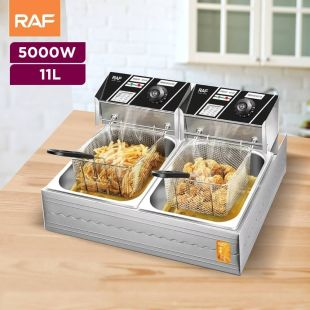
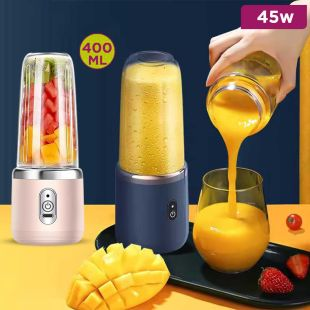
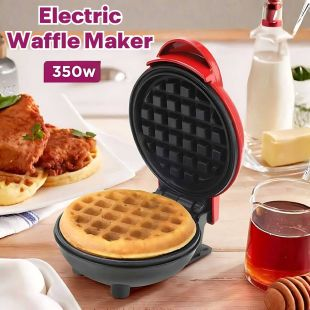

In [ ]:
# Install required packages (only needed in Colab)
# !pip install requests beautifulsoup4 pandas lxml

import requests
from bs4 import BeautifulSoup
import time
import os
import pandas as pd
import zipfile
from IPython.display import display, HTML
import re

BASE_URL = "https://www.sheeel.com/en/electronics.html"
HEADERS = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

MAX_PRODUCTS = 120
products = []
page = 1

# Folder for images
IMAGES_FOLDER = "sheeel_images"
os.makedirs(IMAGES_FOLDER, exist_ok=True)

def clean_price(price_text):
    """Extract numeric value from price string."""
    numbers = re.findall(r"[\d.,]+", price_text)
    if numbers:
        return float(numbers[0].replace(",", ""))
    return 0.0

while len(products) < MAX_PRODUCTS:
    print(f"Scraping page {page}...")
    url = f"{BASE_URL}?p={page}"
    response = requests.get(url, headers=HEADERS, timeout=20)
    if response.status_code != 200:
        print("Failed to load page")
        break

    soup = BeautifulSoup(response.text, "lxml")
    items = soup.select("li.product-item")
    if not items:
        print("No more products found")
        break

    for item in items:
        if len(products) >= MAX_PRODUCTS:
            break

        name_tag = item.select_one(".product-item-link")
        name = name_tag.text.strip() if name_tag else "N/A"
        product_url = name_tag["href"] if name_tag else "N/A"

        price_tag = item.select_one(".price")
        price = price_tag.text.strip() if price_tag else "N/A"
        numeric_price = clean_price(price)

        # --- START MODIFICATION ---
        # Robust image extraction: prioritize 'data-src' and specific product image class
        img_element = item.select_one(".product-image-photo")
        if not img_element: # Fallback to a general image tag if specific class not found
            img_element = item.select_one("img")

        image_url = "N/A"
        if img_element:
            # Prioritize data-src for actual image source (common for lazy loading)
            if img_element.get("data-src"):
                image_url = img_element["data-src"]
            # Fallback to src
            elif img_element.get("src"):
                image_url = img_element["src"]

        img_path = ""
        # Download image with price in filename
        if image_url != "N/A":
            try:
                img_data = requests.get(image_url, headers=HEADERS, timeout=20).content
                safe_name = "".join(c if c.isalnum() else "_" for c in name)[:40]
                price_str = f"{numeric_price:.2f}".replace(".", "_")

                # Extract extension robustly, handle query parameters
                ext = image_url.split(".")[-1].split("?")[0].lower()
                if len(ext) > 4 or not ext.isalnum(): # Simple check for valid extension
                    ext = "jpg" # Default if extension looks weird or is missing

                img_path = os.path.join(IMAGES_FOLDER, f"{safe_name}_{price_str}.{ext}")
                with open(img_path, "wb") as f:
                    f.write(img_data)
            except Exception as e:
                print(f"Failed to download image for {name}: {e}")
        # --- END MODIFICATION ---

        products.append({
            "name": name,
            "price": price,
            "numeric_price": numeric_price,
            "product_url": product_url,
            "image_path": img_path, # img_path is already empty if download fails or image_url is N/A
            "image_url": image_url
        })

    page += 1
    time.sleep(2)

print(f"\nScraped {len(products)} products")

# Convert to DataFrame
df = pd.DataFrame(products)

# Add summary row
total_products = len(df)
avg_price = df["numeric_price"].mean() if total_products > 0 else 0
summary = pd.DataFrame([{
    "name": "TOTAL / AVERAGE",
    "price": f"Average: {avg_price:.2f}",
    "numeric_price": avg_price,
    "product_url": "",
    "image_path": "",
    "image_url": ""
}])
df = pd.concat([df, summary], ignore_index=True)

# Save CSV
csv_file = "sheeel_electronics_120_products.csv"
df.to_csv(csv_file, index=False, encoding="utf-8")
print(f"Saved CSV: {csv_file}")

# Create ZIP
zip_filename = "sheeel_electronics_120_products.zip"
with zipfile.ZipFile(zip_filename, "w") as zipf:
    zipf.write(csv_file)
    for img_file in os.listdir(IMAGES_FOLDER):
        img_path = os.path.join(IMAGES_FOLDER, img_file)
        zipf.write(img_path, arcname=os.path.join("images", img_file))
print(f"Created ZIP: {zip_filename}")

# Inline image preview for Jupyter Notebook with clickable images
def clickable_image_html(local_path, full_url):
    return f'<a href="{full_url}" target="_blank"><img src="{local_path}" width="80"></a>'

df_preview = df.copy()
df_preview['Image'] = df_preview.apply(
    lambda row: clickable_image_html(row['image_path'], row['image_url']) if row['image_path'] else "", axis=1
)
df_preview_display = df_preview[['Image', 'name', 'price', 'product_url']]

display(HTML(df_preview_display.to_html(escape=False)))

In [ ]:
print('First 5 rows of the Image column in df_preview_display:')
display(df_preview_display['Image'].head())

First 5 rows of the Image column in df_preview_display:


,Image
0,"<a href=""https://cdn.sheeel.com/catalog/produc..."
1,"<a href=""https://cdn.sheeel.com/catalog/produc..."
2,"<a href=""https://cdn.sheeel.com/catalog/produc..."
3,"<a href=""https://cdn.sheeel.com/catalog/produc..."
4,"<a href=""https://cdn.sheeel.com/catalog/produc..."
